In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import *
from scipy.signal import kaiserord, lfilter, firwin, freqz, spectrogram

In [0]:
def low_pass_filter(y, cutoff, sr, transition_width = 5.0, ripple_db = 60.0):
  nyq_rate = sr / 2.0
  width = transition_width/nyq_rate

  # Compute the order and Kaiser parameter for the FIR filter.
  N, beta = kaiserord(ripple_db, width)

  # Use firwin with a Kaiser window to create a lowpass FIR filter.
  taps = firwin(N, cutoff/nyq_rate, window=('kaiser', beta))

  # Use lfilter to filter x with the FIR filter.
  return lfilter(taps, 1.0, y)

def bandpass_filter(y, cutoff, sr, transition_width = 5.0, ripple_db = 60.0):
  nyq_rate = sr / 2.0
  width = transition_width/nyq_rate

  # Compute the order and Kaiser parameter for the FIR filter.
  N, beta = kaiserord(ripple_db, width)

  # Use firwin with a Kaiser window to create a lowpass FIR filter.
  taps = firwin(N, [i/nyq_rate for i in cutoff], window=('kaiser', beta),pass_zero=False)

  # Use lfilter to filter x with the FIR filter.
  return lfilter(taps, 1.0, y)

def low_pass_digital(S, dt = 70, ts = 50):
  low = []
  alpha = dt/(dt+ts)
  low.append((1-alpha)*S[0])
  for i in range(1,len(S)):
    g = (1-alpha)*S[i] + alpha*low[i-1]
    low.append(g)
  return low

def pitch_contour(S):
  pitch = []
  i,j = S.shape
  step = np.ones(j)
  for k in range(0,j):
    temp = np.where(S[:,k]==np.amax(S[:,k]))
    pitch.append(temp[0][0])
    if np.amax(S[:,k]) < -18:  
      step[k] = np.nan
  pitch = [ freq_cqt[i] for i in pitch]
  pitch = low_pass_digital(pitch)
  pitch = [a*b for a,b in zip(pitch,step)]
  return pitch

In [0]:
freq_cqt = librosa.cqt_frequencies(90, fmin=32)
path_Surabhi = '/content/drive/My Drive/Projects/AA/Music dataset/Raga_Surabhi_3.wav'
path_Ahir = '/content/drive/My Drive/Projects/AA/Music dataset/Ahir_bhairavi.wav'
path_sa_re = '/content/drive/My Drive/Projects/AA/Music dataset/sa_re.wav'
path_sa_re_h = '/content/drive/My Drive/Projects/AA/Music dataset/SaRe_hindusthani.wav'
path_Kalyani_0 = '/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_0.wav'
path_Kalyani_1 = '/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_1.wav'
path_Kalyani_2 = '/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_2.wav'
path_TNSG = '/content/drive/My Drive/Projects/AA/Music dataset/TNSG.wav'
#ipd.Audio(x, rate=sr)

In [0]:
path1 = path_Surabhi
path2  = path_Kalyani_1

In [0]:
x1, sr1 = librosa.load(path1,sr = None )
x1 = bandpass_filter(y = x1, cutoff = [110.0, 500.0], sr = sr1)
x2,sr2 = librosa.load(path2, sr=None,duration = 20)
x2 = bandpass_filter(y = x2, cutoff = [110.0, 500.0], sr = sr2)

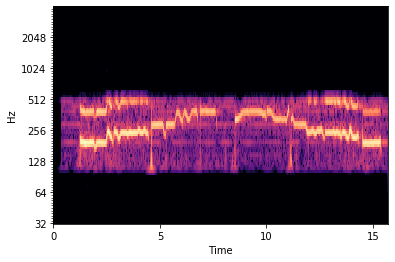

In [18]:
C1 = librosa.cqt(x1,sr=sr1)
logC1 = librosa.amplitude_to_db(np.abs(C1),ref = np.max)
C2 = librosa.cqt(x2,sr=sr2,fmin = None,n_bins= 84)
logC2 = librosa.amplitude_to_db(np.abs(C2),ref = np.max)

#librosa.display.specshow(logC, sr=sr, x_axis='time',y_axis = 'log') # stft
librosa.display.specshow(logC1, sr=sr1, x_axis='time',y_axis = 'cqt_hz') # cqt


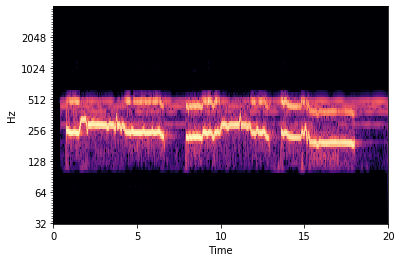

In [19]:
librosa.display.specshow(logC2, sr=sr2, x_axis='time',y_axis = 'cqt_hz') # c

C1.shape = X,y
X = rows
Y = column

In [0]:
pitch_1 = pitch_contour(logC1)
pitch_2 = pitch_contour(logC2)

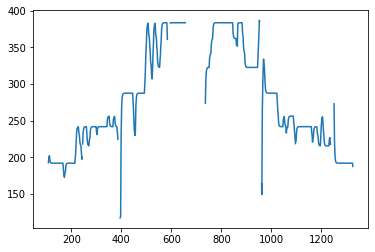

In [21]:
plt.plot(pitch_1)
#print(pitch_1)

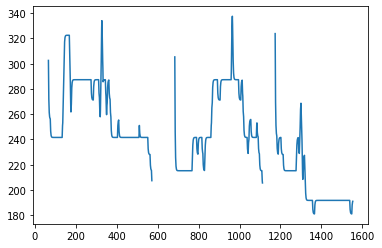

In [22]:
plt.plot(pitch_2)

In [0]:
#plt.plot(np.correlate(pitch_1,pitch_2,"full"))